In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import os, re
import seaborn as sns
from tqdm.notebook import tqdm, trange
# import src.utils
import importlib
# importlib.reload(src.utils)
from matplotlib.lines import Line2D
from multiprocessing import Pool

In [65]:
remove_mean = False
data = xr.open_dataset("/p/project1/training2533/lancelin1/WeGenDiffusion/data/2011_t2m_era5_2deg.nc")
mean_field = data['t2m'].mean(dim='valid_time').values
std = data.std()['t2m'].values  
mean = data.mean()['t2m'].values
mean_field.shape
n_rollouts = 9

# Load the predictions and post-process them
preds = []
for i in range(1,n_rollouts+1):
    path_fcst= f"/p/project1/training2533/lancelin1/WeGenDiffusion/samples/forecast/DiT-B-2_previous_state_1_rollout_{i}.npy"
    pred = np.load(path_fcst) 
    pred = pred.squeeze(1)
    pred = mean + std*pred # unnormalize the predictions
    if remove_mean:
        pred = pred - mean_field
    preds.append(pred)
preds = np.array(preds)


# Load the truth
truths = []
path_truth = "/p/project1/training2533/lancelin1/WeGenDiffusion/data/2011_t2m_era5_2deg.nc"
data = xr.open_dataset(path_truth)
indices = np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
for i in range(1,n_rollouts+1):
    lead_time = i
    truth = data.isel(valid_time=indices+lead_time)['t2m'].values
    if remove_mean:
        truth = truth - mean_field
    truths.append(truth)
truths = np.array(truths)


# swap the first and second dimension
preds = preds.swapaxes(0, 1)
truths = truths.swapaxes(0, 1)
print(preds.shape,truths.shape) # (n_initial_conditions, n_rollouts, n_lats, n_lons)

(11, 9, 90, 180) (11, 9, 90, 180)


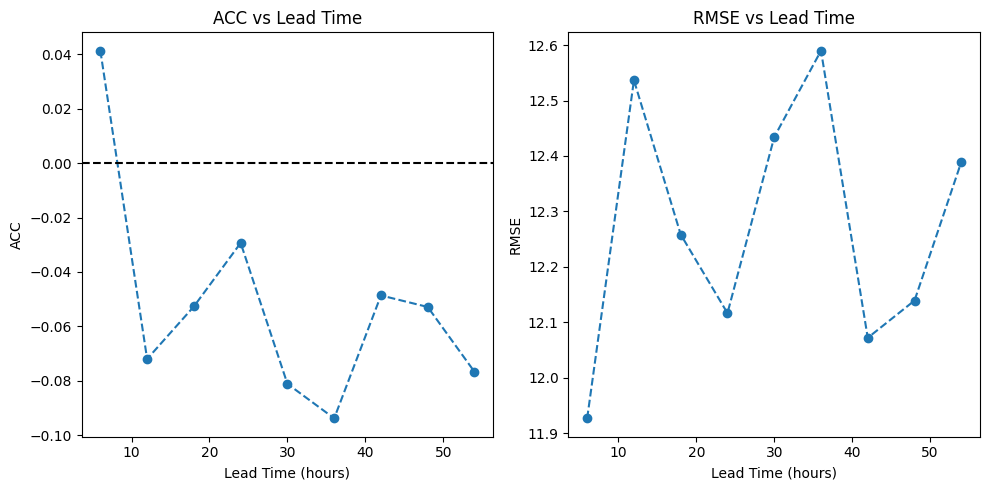

In [71]:
import numpy as np

def compute_ACC(forecasts, truths, climatology, axis=(0,2,3)):
    """
    Compute Anomaly Correlation Coefficient (ACC).

    Parameters
    ----------
    forecast : np.ndarray
        Forecast data with shape (n_initial_conditions, n_rollouts, n_lons, n_lats)
    analysis : np.ndarray
        Analysis (truth) data, same shape as forecast
    climatology : np.ndarray or None
        Climatology with shape (n_rollouts, n_lons, n_lats) or broadcastable
        If None, computed as mean over axis
    axis : tuple
        Axes over which to compute mean climatology (default: (0,) = mean over initial conditions)

    Returns
    -------
    acc : np.ndarray
        ACC values with shape (n_rollouts, n_lons, n_lats)
    """

    f_anom = forecasts - climatology
    a_anom = truths - climatology

    numerator = np.sum(f_anom * a_anom, axis=axis)
    denominator = np.sqrt(np.sum(f_anom**2, axis=axis) * np.sum(a_anom**2, axis=axis))

    acc = numerator / denominator
    return acc


# compute ACC
acc = compute_ACC(preds, truths, mean_field)   
# compute RMSE between truth and prediction
rmse = np.mean(np.sqrt(np.mean((truths - preds)**2, axis=(2, 3))), axis=0)


# Create a two subplot figure: ACC and RMSE as a function of lead time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# ACC subplot
ax1.plot(np.arange(1, len(acc) + 1)*6, acc, linestyle='--', marker='o')
ax1.set_xlabel('Lead Time (hours)')
ax1.set_ylabel('ACC')
ax1.set_title('ACC vs Lead Time')
ax1.axhline(y=0, color='black', linestyle='--')

# RMSE subplot
ax2.plot(np.arange(1, len(rmse) + 1)*6, rmse, linestyle='--', marker='o')
ax2.set_xlabel('Lead Time (hours)')
ax2.set_ylabel('RMSE')
ax2.set_title('RMSE vs Lead Time')

plt.tight_layout()
plt.show()


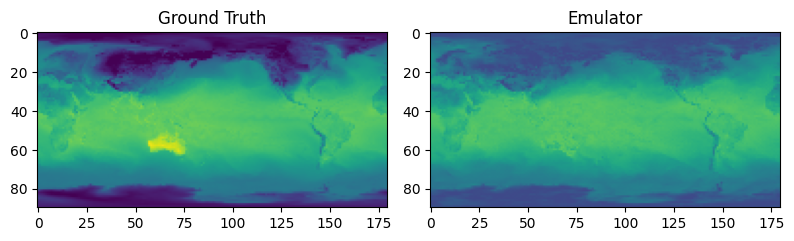

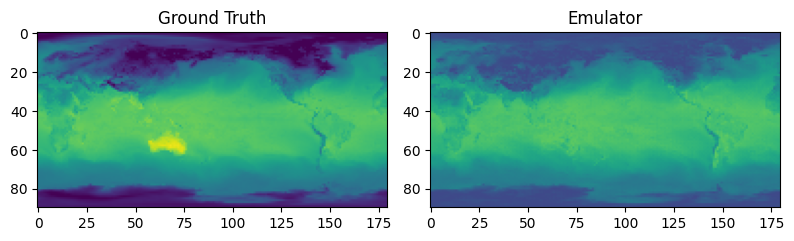

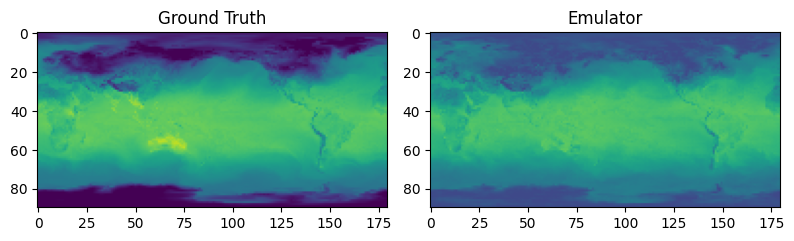

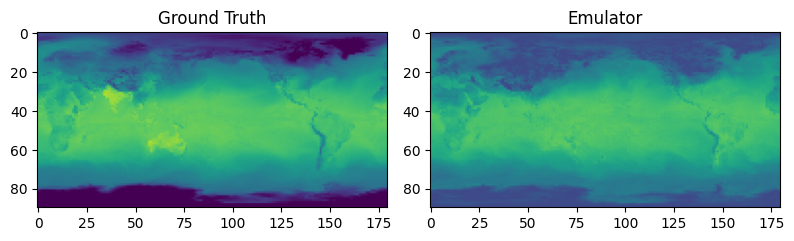

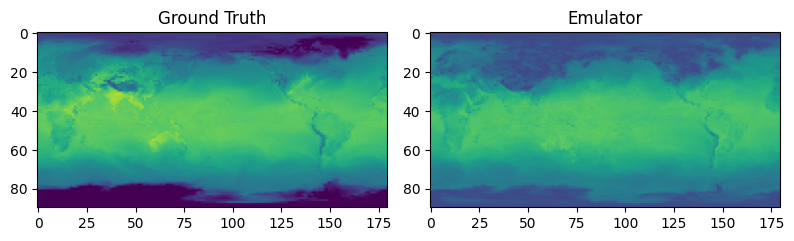

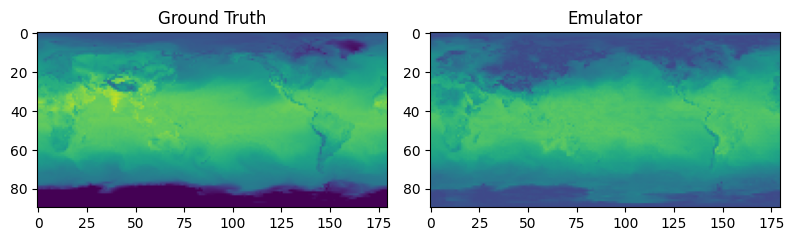

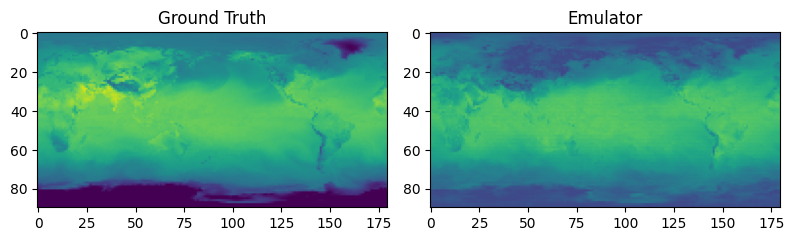

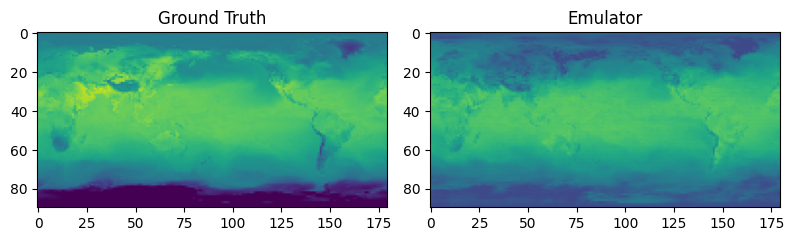

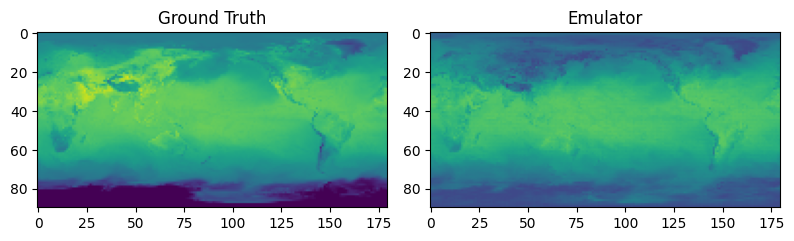

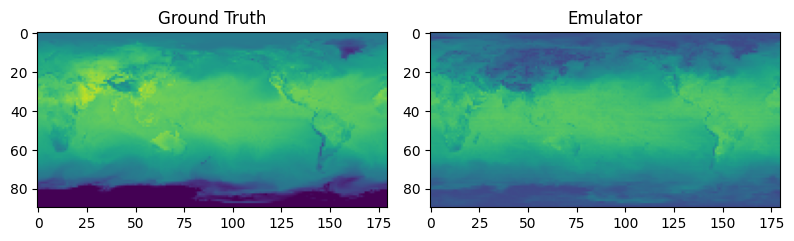

In [64]:
### INSPECT SOME SAMPLES
for index in range(10):
    anom_prediction =  preds[index, 0]
    anom_truth = truths[index, 0]
    # plot the anomalies at first time step
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

    if remove_mean:
        vmin = -25
        vmax = 25
        cmap = "RdBu_r"
    else:
        vmin = 240
        vmax = 320
        cmap = "viridis"

    # Plot truth
    # reverse image
    im1 = ax1.imshow(anom_truth[::-1, :], cmap=cmap, vmin=vmin, vmax=vmax)
    ax1.set_title("Ground Truth")
    # plt.colorbar(im1, ax=ax1)

    # Plot prediction
    im2 = ax2.imshow(anom_prediction[::-1, :], cmap=cmap, vmin=vmin, vmax=vmax)
    ax2.set_title("Emulator")
    # plt.colorbar(im2, ax=ax2)

    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import imageio
import os

skip_existing = False
path_to_save_gif = "./"

# === Load data ===
# Replace this with the path to your data
zg_truth = anom_truth.isel(time=slice(0, 200))
zg_pred = anom_prediction.isel(time=slice(0, 200))
times = zg_truth.time.values

# === Animation Parameters ===
n_frames = len(times)
fps = 10

# === Output frames ===
output_dir = "/p/project1/training2533/lancelin1/WeGenDiffusion/samples/gif"
os.makedirs(output_dir, exist_ok=True)

# === Create each frame ===
if not skip_existing and os.path.exists(output_dir):
    for i in trange(n_frames):
        fig = plt.figure(figsize=(8, 4.5))  # Reduced figure width
        
        # Truth plot
        ax1 = plt.subplot(121, projection=ccrs.Orthographic(central_longitude= - i * 180 / (n_frames * 2), central_latitude=20)) # 3 is the rotation speed
        ax1.set_global()
        ax1.coastlines()
        ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
        
        # Plot truth field at time i
        zg_truth_i = zg_truth.isel(time=i)
        lon, lat = np.meshgrid(zg_truth.lon, zg_truth.lat)
        cs1 = ax1.pcolormesh(lon, lat, zg_truth_i, transform=ccrs.PlateCarree(), cmap='RdBu_r', 
                            vmin=-np.max(np.abs(zg_truth_i)), vmax=np.max(np.abs(zg_truth_i)))
        ax1.set_title("Ground Truth", fontsize=14, y=1.03, pad=0.2)
        
        # Prediction plot
        ax2 = plt.subplot(122, projection=ccrs.Orthographic(central_longitude= - i * 180 / (n_frames * 2), central_latitude=20))
        ax2.set_global()
        ax2.coastlines()
        ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
        
        # Plot prediction field at time i
        zg_pred_i = zg_pred.isel(time=i)
        cs2 = ax2.pcolormesh(lon, lat, zg_pred_i, transform=ccrs.PlateCarree(), cmap='RdBu_r', 
                            vmin=-np.max(np.abs(zg_pred_i)), vmax=np.max(np.abs(zg_pred_i)))
        ax2.set_title("Emulator", fontsize=14, y=1.03, pad=0.2)
        
        # # Add a single colorbar for both plots
        # cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.02])  # Position colorbar below both plots
        # cbar = fig.colorbar(cs1, cax=cbar_ax, orientation='horizontal')
        
        # plt.suptitle(f"Time: {str(times[i])}", fontsize=12)
        plt.suptitle(f"Geopotential height anomaly at 500 hPa \n Lead time: {i//4} day(s)", fontsize=16)
        
        # Save frame
        frame_path = os.path.join(output_dir, f"frame_{i:03d}.png")
        fig.tight_layout()
        plt.savefig(frame_path, dpi=100, bbox_inches='tight')
        plt.close()

# === Create GIF ===
images = [imageio.imread(os.path.join(output_dir, f"frame_{i:03d}.png")) for i in range(n_frames)]
imageio.mimsave(path_to_save_gif + f"/zg_globe_rotation_comparison_nframes{n_frames}_emulator.gif", images, fps=fps, loop=0)

print(f"✅ GIF saved as 'zg_globe_rotation_comparison_nframes{n_frames}_emulator.gif'")

  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_2117730/3026501627.py:70: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(os.path.join(output_dir, f"frame_{i:03d}.png")) for i in range(n_frames)]


✅ GIF saved as 'zg_globe_rotation_comparison_nframes200_emulator.SFNO-no-soil.gif'
